In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [29]:
image = cv2.imread("ref_image.jpg")

#### Corners

1. Top Left (0, 50)
2. Top Right (600, 50)
3. Bottom Left(0, 360)
4. Bottom Right(600, 360)

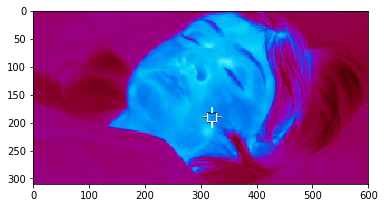

In [30]:
image_new = image[50:360, 0:600]
plt.imshow(image_new)

## Selecting ROI and reading Video

In [55]:
cap = cv2.VideoCapture("12.avi")

while not cap.isOpened():
    cap = cv2.VideoCapture("12.avi")
    cv2.waitKey(1000)
    print("Wait for the header")

pos_frame = cap.get(cv2.CAP_PROP_POS_FRAMES)
fps = cap.get(cv2.CAP_PROP_FPS)

In [56]:
# https://www.pyimagesearch.com/2015/03/09/capturing-mouse-click-events-with-python-and-opencv/
refPt = []
cropping = False
title = "press 'n' for next, 'r' to reset, 'c' to stop"

def click_and_crop(event, x, y, flags, param):
    # grab references to the global variables
    global refPt, cropping
    
    # if the left mouse button is pressed, record the starting (x, y)
    # coordinates and indicate that cropping is being performed
    if event == cv2.EVENT_LBUTTONDOWN:
        refPt = [(x, y)]
        cropping = True
    
    # check to see if the left mouse button was released
    elif event == cv2.EVENT_LBUTTONUP:
        # record the ending (x, y) coordinates and indicate that
        # the cropping operation is finished
        refPt.append((x, y))
        cropping = False
        
        # draw a rectangle around the region of interest
        cv2.rectangle(image, refPt[0], refPt[1], (0, 255, 0), 2)
        cv2.imshow(title , image)

In [57]:
# # construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--image", required=True, help="Path to the image")
# args = vars(ap.parse_args())
 
# load the image, clone it, and setup the mouse callback function
flag, image = cap.read() 
clone = image.copy()
cv2.namedWindow(title)
cv2.setMouseCallback(title, click_and_crop)
 
# keep looping until the 'q' key is pressed
while True:

    # display the image and wait for a keypress
    cv2.imshow(title, image)
    key = cv2.waitKey(1) & 0xFF
 
    # if the 'n' key is pressed, give a frame after 1 sec
    # for reselecting ROI
    if key == ord("n"):
        if cap.get(cv2.CAP_PROP_POS_FRAMES) + fps >= cap.get(cv2.CAP_PROP_FRAME_COUNT):
            print("No more frames!")
            break
        pos_frame = pos_frame + fps
        cap.set(cv2.CAP_PROP_POS_FRAMES, pos_frame)
        flag, image = cap.read()
        clone = image.copy()
        cv2.namedWindow(title)
        cv2.setMouseCallback(title, click_and_crop)
    
    
    # if the 'r' key is pressed, reset the cropping region
    if key == ord("r"):
        image = clone.copy()
 
    # if the 'c' key is pressed, break from the loop
    elif key == ord("c"):
        break
 
# if there are two reference points, then crop the region of interest
# from teh image and display it
if len(refPt) == 2:
    roi = clone[refPt[0][1]:refPt[1][1], refPt[0][0]:refPt[1][0]]
    cv2.imshow("ROI", roi)
    cv2.waitKey(0)
 
# close all open windows
cv2.destroyAllWindows()

In [58]:
ref_frame_pos = pos_frame

## Observation

x and y in opencv and paint are reversed

In [59]:
def removeMarker(image): 
    imageSansMarker = image[50:360, 0:600]
    return imageSansMarker

In [60]:
def centroid(image, threshold = 127):
    image = removeMarker(image)
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, thresh1 = cv2.threshold(image_gray,127,255,cv2.THRESH_BINARY)
    Mom = cv2.moments(thresh1)
    X = int(Mom["m10"]/ Mom["m00"])
    Y = int(Mom["m01"]/ Mom["m00"])
    return (X,Y)

### Saving reference frame and initial centroid

In [61]:
cap.set(cv2.CAP_PROP_POS_FRAMES, ref_frame_pos)

flag, frame = cap.read()
cv2.imwrite("ref_image.jpg", frame)

cX, cY = centroid(frame)

In [62]:
cap.set(cv2.CAP_PROP_POS_FRAMES, ref_frame_pos)
while True:
    flag, frame = cap.read()
    key = cv2.waitKey(100) & 0xFF
    if key == ord("q"):
        break
    if flag:
        pos_frame = cap.get(cv2.CAP_PROP_POS_FRAMES)
        cX_new, cY_new = centroid(frame)
        newROI = [(refPt[0][0] + cX - cX_new, refPt[0][1] + cY - cY_new)];
        newROI.append(((refPt[1][0] + cX - cX_new), (refPt[1][1] + cY - cY_new)))
        cv2.rectangle(frame, newROI[0], newROI[1], (0, 0, 255), 2)
        cv2.imshow("ROI Tracking", frame)
    else:
        cap.set(cv2.CAP_PROP_POS_FRAMES, pos_frame-1)
        print("frame is not ready")
    if cap.get(cv2.CAP_PROP_POS_FRAMES) == cap.get(cv2.CAP_PROP_FRAME_COUNT):
        # If the number of captured frames is equal to the total number of frames,
        # we stop
        break
cv2.destroyAllWindows()

### Observation

Big Orientation change at 5:24:01

In [63]:
def calculateDistance(first, second):
    x = second[0] - first[0]
    y = second[1] - first[1]
    return (x**2.0 + y**2.0)**0.5

In [64]:
cap.set(cv2.CAP_PROP_POS_FRAMES, ref_frame_pos)
signal = np.array([])
while True:
    flag, frame = cap.read()
    key = cv2.waitKey(100) & 0xFF
    if key == ord("q"):
        break
    if flag:
        pos_frame = cap.get(cv2.CAP_PROP_POS_FRAMES)
        roi = frame[refPt[0][1]:refPt[1][1], refPt[0][0]:refPt[1][0]]
        roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        M = cv2.moments(roi_gray)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        dist = calculateDistance(refPt[0], (cX, cY))
        signal = np.append(signal, dist)
        cv2.rectangle(frame, refPt[0], refPt[1], (0,0,255), 2)
        cv2.imshow("Extracting Signal", frame)
    else:
        cap.set(cv2.CAP_PROP_POS_FRAMES, pos_frame-1)
        print("frame is not ready")
    if cap.get(cv2.CAP_PROP_POS_FRAMES) == cap.get(cv2.CAP_PROP_FRAME_COUNT):
        # If the number of captured frames is equal to the total number of frames,
        # we stop
        break
cv2.destroyAllWindows()

In [65]:
print(signal)

[ 192.33304448  192.33304448  192.33304448  192.33304448  192.33304448
  192.33304448  192.33304448  192.33304448  192.33304448  192.33304448
  192.33304448  192.33304448  192.33304448  192.33304448  192.33304448
  192.33304448  192.33304448  192.33304448  192.33304448  192.33304448
  192.33304448  192.33304448  192.33304448  192.33304448  192.33304448
  192.33304448  192.33304448  192.33304448  192.33304448  192.33304448
  192.33304448  192.33304448  192.33304448  192.33304448  192.33304448
  192.33304448  192.33304448  192.33304448  192.33304448  192.33304448
  192.33304448  192.33304448  192.33304448  192.33304448  192.33304448
  192.33304448  192.33304448  192.33304448  192.33304448  192.33304448
  192.33304448  192.33304448  192.33304448  192.33304448  192.33304448
  192.33304448  192.33304448  192.33304448  192.33304448  192.33304448
  192.33304448  192.33304448  192.33304448  192.33304448  192.33304448
  192.33304448  192.33304448  192.33304448  192.33304448  192.33304448
  192.

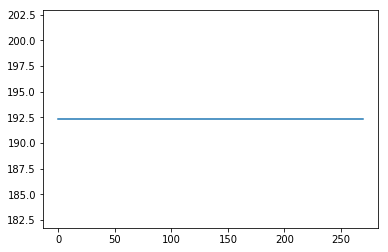

In [66]:
plt.plot(signal)